<a href="https://colab.research.google.com/github/MominAhmedShaikh/ANN-model-Regression/blob/main/ANN_video_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies and importing libraries

In [1]:
!pip install -U keras-tuner -q
!pip install -U imblearn -q
!pip install -U scikeras -q

     |████████████████████████████████| 135 kB 9.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.8 MB/s 


In [2]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from imblearn.over_sampling import SMOTE
from keras import regularizers
from tensorflow import keras
from keras import models
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.figure_factory as ff
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import keras_tuner
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
tf.random.set_seed(1) #setting seed to keep the environment equal

# Function Definations

In [3]:
def top_sales_sum(df,col1,col2,top_value):
  his = px.histogram(data_frame=df,
                     x = [i for i in df.groupby(col1)[col2].sum().sort_values()[top_value:].index],
                      y = [df.groupby(col1)[col2].sum().sort_values()[top_value:].values])
  return his

In [4]:
def uni_cat_col(df,col):
  his = px.histogram(data_frame=df,
             x = [i for i in df[col].value_counts().index] ,
             y = [df[col].value_counts()[i] for i in range(len(df[col].value_counts().index))])
  return his

In [5]:
def missing_value_plot(ds):
  x = [i for i in ds.columns]
  y1 = [len(ds) for i in range(len(ds.columns))]
  y2 = [ds.isnull().sum()[i] for i in range(len(ds.columns))]
  y1 = np.array(y1)-np.array(y2)

  fig = go.Figure(data=[
      go.Bar(name='Total values', x=x, y=y1),
      go.Bar(name='Missing values', x=x, y=y2)
  ])
  # Change the bar mode
  fig.update_layout(barmode='stack')
  fig.show()

In [6]:
def kdeplot_for_missing_impute(df,col_name,title):
  from statistics import mode

  # Create a subset
  x = df[[col_name]]

  # Assing differently imputed values to different columns
  x['Mean'] = df[col_name].fillna(df[col_name].mean())
  x['Median'] = df[col_name].fillna(df[col_name].median())
  x['Mode'] = df[col_name].fillna(mode(df[col_name]))

  # Obtain summary statistics
  x.describe().T[['mean', 'std', 'min', '50%', 'max']]

  x.plot(kind='kde', figsize=(12, 7), title=title)
  plt.show()
  return   x.describe().T[['mean', 'std', 'min', '50%', 'max']]

In [7]:
def knn_impute_plot(df,column_name):
  from statistics import mode
  x = df[[column_name]].copy()
  x[str(column_name)+'_KNN'] = imputed_orig[column_name]
  x[str(column_name)+'_KNN_Scaled'] = imputed_scaled[column_name]
  x['Mean'] = df[column_name].fillna(df[column_name].mean())
  x['Median'] = df[column_name].fillna(df[column_name].median())
  x['Mode'] = df[column_name].fillna(mode(df[column_name]))

  x.plot(kind = 'kde', figsize = (10,5))
  plt.show()
  # Obtain summary statistics
  return x.describe(include = 'all').T[['mean', 'std', 'min', '50%', '25%', '75%', 'max']]

# Data Processing And Preparation

#### Reading dataset

In [8]:
url = 'https://raw.githubusercontent.com/MominAhmedShaikh/ANN-model-Regression/main/dataset/video_games_sales.csv'
vg_ds = pd.read_csv(url)

#### .head()
- Global Sales is our Target Column.
- There are five columns correponds to Sale.
- Nan values in columns such as Critic_Score, Critic_Count, User_Score, User_Count, Developer	Rating are clearly visible.

In [9]:
vg_ds.head()

Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating  
0          51.0          8       322.0  Nintendo      E  
1           NaN        NaN         NaN       NaN    NaN  
2          73.0        8.3       709.0  Nintendo      E  
3          73.0          8       192.0  Nintendo      E  
4           NaN        NaN         NaN       NaN    NaN

#### .shape()
- The Dataset has 16719 columns and 16 rows

In [10]:
vg_ds.shape

(16719, 16)

#### .describe()
- Mean Global sales is 0.5335, which is greater then rest of the columns correspond to sales.
- Min Global sale was 0.01 and Max was 82.53, which may describe us which developer earned less or more, when we move to further steps in EDA.
- Year of Release ranges from 1980 to 2020 (40 years).

In [11]:
vg_ds.describe().T

count         mean         std      min      25%      50%  \
Year_of_Release  16450.0  2006.487356    5.878995  1980.00  2003.00  2007.00   
NA_Sales         16719.0     0.263330    0.813514     0.00     0.00     0.08   
EU_Sales         16719.0     0.145025    0.503283     0.00     0.00     0.02   
JP_Sales         16719.0     0.077602    0.308818     0.00     0.00     0.00   
Other_Sales      16719.0     0.047332    0.186710     0.00     0.00     0.01   
Global_Sales     16719.0     0.533543    1.547935     0.01     0.06     0.17   
Critic_Score      8137.0    68.967679   13.938165    13.00    60.00    71.00   
Critic_Count      8137.0    26.360821   18.980495     3.00    12.00    21.00   
User_Count        7590.0   162.229908  561.282326     4.00    10.00    24.00   

                     75%       max  
Year_of_Release  2010.00   2020.00  
NA_Sales            0.24     41.36  
EU_Sales            0.11     28.96  
JP_Sales            0.04     10.22  
Other_Sales         0.03     10.57  
Global_Sales        0.47     82.53  
Critic_Score       79.00     98.00  
Critic_Count       36.00    113.00  
User_Count         81.00  10665.00

#### .isnull() 
- Total Number of Missing values in Dataset is 46716.
- User Count has Max Number of Missing values about 9129 (54.60%).
- There are 6 columns with more then 40% of null values.

##### Null value summary

In [12]:
vg_ds.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [13]:
vg_ds.isnull().mean() * 100

Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64

In [14]:
vg_ds.isnull().sum().sum()

46716

##### Dealing with NULL values

In [15]:
missing_value_plot(vg_ds)

In [16]:
# We can see that few columns conatin 50% null value per row and also their global sales is less than 0.10 we can 
vg_ds[vg_ds.isnull().any(axis = 1)].tail()

Name Platform  Year_of_Release       Genre  \
16714  Samurai Warriors: Sanada Maru      PS3           2016.0      Action   
16715               LMA Manager 2007     X360           2006.0      Sports   
16716        Haitaka no Psychedelica      PSV           2016.0   Adventure   
16717               Spirits & Spells      GBA           2003.0    Platform   
16718            Winning Post 8 2016      PSV           2016.0  Simulation   

          Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
16714    Tecmo Koei      0.00      0.00      0.01          0.0          0.01   
16715   Codemasters      0.00      0.01      0.00          0.0          0.01   
16716  Idea Factory      0.00      0.00      0.01          0.0          0.01   
16717       Wanadoo      0.01      0.00      0.00          0.0          0.01   
16718    Tecmo Koei      0.00      0.00      0.01          0.0          0.01   

       Critic_Score  Critic_Count User_Score  User_Count Developer Rating  
16714           NaN           NaN        NaN         NaN       NaN    NaN  
16715           NaN           NaN        NaN         NaN       NaN    NaN  
16716           NaN           NaN        NaN         NaN       NaN    NaN  
16717           NaN           NaN        NaN         NaN       NaN    NaN  
16718           NaN           NaN        NaN         NaN       NaN    NaN

In [17]:
nan_vals = vg_ds[vg_ds['Global_Sales'] < 0.1].isnull()
vg_ds = vg_ds.drop(nan_vals.index)

In [18]:
vg_ds.shape

(10827, 16)

###### Rating Column Null Value Imputation
- Imputing Rating column with its mode 'E' will make column's distribution more centric towards one value. Hence we will replace it with Arbitrary value 'NK' (Not Known).

In [19]:
vg_ds['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC'], dtype=object)

In [20]:
imputer = SimpleImputer(strategy='constant',fill_value='NK')
vg_ds['Rating'] = imputer.fit_transform(vg_ds[['Rating']])

###### Developer Column Null Value Imputation
- Imputing Developer column with its mode 'Nitendo' will make column's distribution more centric towards one value. Hence we will replace it with Arbitrary value 'Not Known'

In [21]:
vg_ds['Developer'].unique()

array(['Nintendo', nan, 'Good Science Studio', ..., 'B.B.Studio',
       'Scientifically Proven', '8Monkey Labs'], dtype=object)

In [22]:
imputer = SimpleImputer(strategy='constant',fill_value='Not known')
vg_ds['Developer'] = imputer.fit_transform(vg_ds[['Developer']])

###### Year_of_Release Null Value Imputation
- Imputing Year_of_Release column with its median 2007 will make column's distribution more centric.
- Mean and mode of Year_of_Release was 2006 , 2008 respectively.

In [23]:
imputer = SimpleImputer(strategy='median',missing_values=np.nan)
vg_ds['Year_of_Release'] = imputer.fit_transform(vg_ds[['Year_of_Release']])

###### Genre Null Value Imputation
- Though Genre has only one missing value, But we will still impute it with mode.

In [24]:
imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
vg_ds['Genre'] = imputer.fit_transform(vg_ds[['Genre']])

###### Publisher Null Value Imputation
- Publisher has 32 Null values, we will impute it with mode.

In [25]:
imputer = SimpleImputer(strategy='most_frequent',missing_values=np.nan)
vg_ds['Publisher'] = imputer.fit_transform(vg_ds[['Publisher']])

##### User Score datatype conversion
- User_Score is in object datatype but we will convert it into float datatype.
- We were unable to convert this User_Score column to float64 directly because it had 1 str value 'tbd'.
- First we need to handle this value then we can convert this column's datatype to float64.
- Occurance of 'tbd' is 2425 which is 14.5% of whole column.
- We can follow either of the two ways
 - We can convert this value into some Arbitrary value.
 - We can convert this value into Nan values and later treat them with Nan Values.
- We will follow second appraoch as we don't know much about data.

In [26]:
vg_ds['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9'], dtype=object)

In [27]:
count = 0
for i in vg_ds['User_Score']:
  if i == 'tbd':
    count += 1
count

1302

In [28]:
vg_ds['User_Score'] = vg_ds['User_Score'].replace('tbd',np.nan)

In [29]:
vg_ds['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9'], dtype=object)

In [30]:
vg_ds['User_Score'] = vg_ds['User_Score'].astype(float)

In [31]:
vg_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10827 entries, 0 to 10826
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             10826 non-null  object 
 1   Platform         10827 non-null  object 
 2   Year_of_Release  10827 non-null  float64
 3   Genre            10827 non-null  object 
 4   Publisher        10827 non-null  object 
 5   NA_Sales         10827 non-null  float64
 6   EU_Sales         10827 non-null  float64
 7   JP_Sales         10827 non-null  float64
 8   Other_Sales      10827 non-null  float64
 9   Global_Sales     10827 non-null  float64
 10  Critic_Score     6092 non-null   float64
 11  Critic_Count     6092 non-null   float64
 12  User_Score       5882 non-null   float64
 13  User_Count       5882 non-null   float64
 14  Developer        10827 non-null  object 
 15  Rating           10827 non-null  object 
dtypes: float64(10), object(6)
memory usage: 1.4+ MB


##### User_Score , User_Count , Critic_Score , Critic_Count Null Value Imputaion

In [32]:
vg_ds.isnull().sum()

Name                  1
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       4735
Critic_Count       4735
User_Score         4945
User_Count         4945
Developer             0
Rating                0
dtype: int64

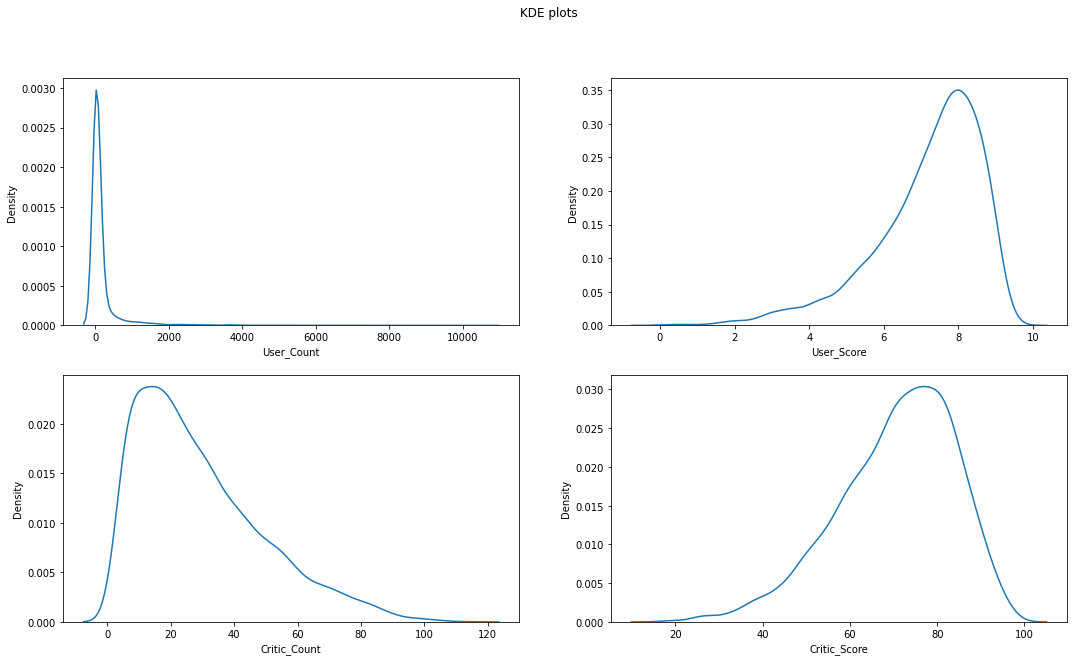

In [33]:
cols = ['Critic_Score','Critic_Count','User_Score','User_Count']

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
sns.kdeplot(vg_ds['User_Count'],ax = axes[0,0])
sns.kdeplot(vg_ds['User_Score'],ax = axes[0,1])
sns.kdeplot(vg_ds['Critic_Count'],ax = axes[1,0])
sns.kdeplot(vg_ds['Critic_Score'],ax = axes[1,1])
plt.suptitle("KDE plots")
plt.show()

In [34]:
# the corr is less between columns hence we will not use iterative imputer
x = list(vg_ds.corr().columns)
y = list(vg_ds.corr().index)
z = np.array(vg_ds.corr())

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()

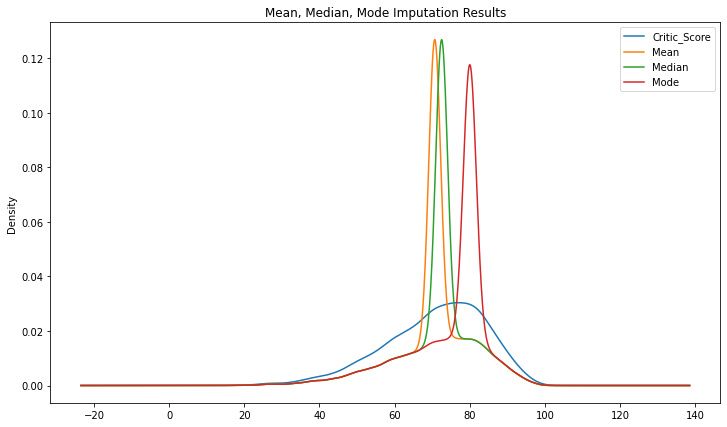

mean        std   min        50%   max
Critic_Score  70.667269  13.457965  17.0  72.500000  98.0
Mean          70.667269  10.094613  17.0  70.667269  98.0
Median        71.468782  10.135474  17.0  72.500000  98.0
Mode          74.748776  11.105679  17.0  80.000000  98.0

In [35]:
kdeplot_for_missing_impute(vg_ds,'Critic_Score','Mean, Median, Mode Imputation Results')

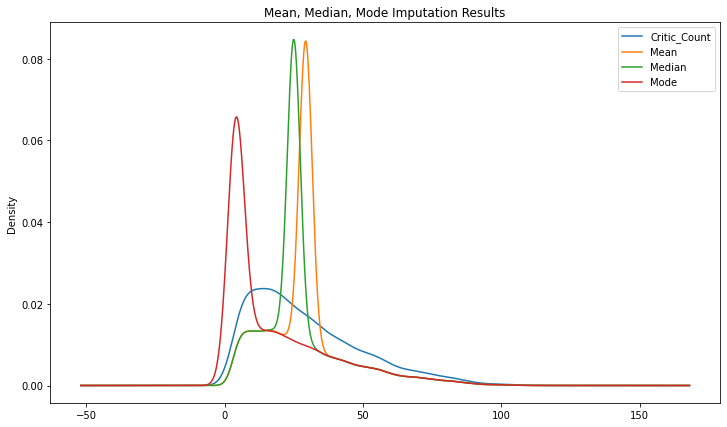

mean        std  min        50%    max
Critic_Count  29.275772  19.985542  3.0  25.000000  113.0
Mean          29.275772  14.990849  3.0  29.275772  113.0
Median        27.405837  15.140169  3.0  25.000000  113.0
Mode          18.221853  19.543471  3.0   8.000000  113.0

In [36]:
kdeplot_for_missing_impute(vg_ds,'Critic_Count','Mean, Median, Mode Imputation Results')

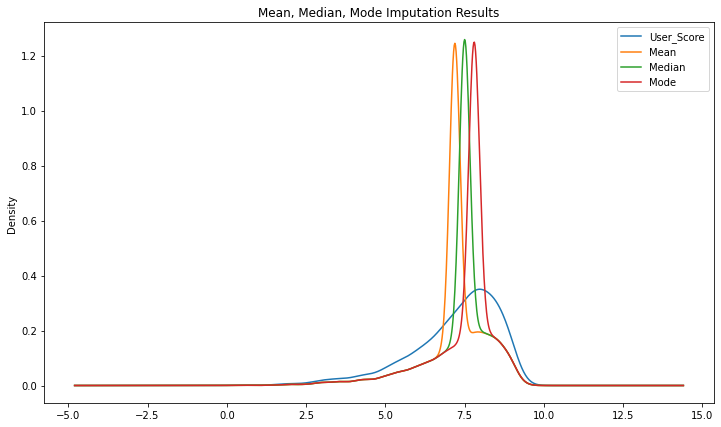

mean       std  min       50%  max
User_Score  7.190751  1.439805  0.0  7.500000  9.6
Mean        7.190751  1.061195  0.0  7.190751  9.6
Median      7.331994  1.072318  0.0  7.500000  9.6
Mode        7.469013  1.103741  0.0  7.800000  9.6

In [37]:
kdeplot_for_missing_impute(vg_ds,'User_Score','Mean, Median, Mode Imputation Results')

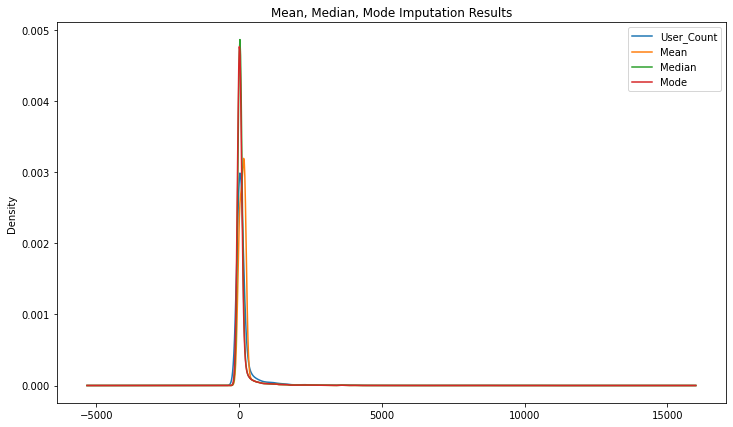

mean         std  min        50%      max
User_Count  184.327780  608.288117  4.0   28.00000  10665.0
Mean        184.327780  448.333211  4.0  184.32778  10665.0
Median      112.928420  455.046220  4.0   28.00000  10665.0
Mode        102.880392  457.049288  4.0    6.00000  10665.0

In [38]:
kdeplot_for_missing_impute(vg_ds,'User_Count','Mean, Median, Mode Imputation Results')

In [39]:
num_col = []
for i in vg_ds.columns:
  if vg_ds[i].dtype==float:
    num_col.append(i)

    
from sklearn.preprocessing import MinMaxScaler
new_ds = vg_ds.drop(columns=[i for i in vg_ds.columns if i not in num_col])
# Original dataset
data_original = new_ds

# Scaled dataset
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_original)
data_scaled = pd.DataFrame(data=data_scaled, columns=data_original.columns)
data_scaled.head()

Year_of_Release  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0            0.650  1.000000  1.000000  0.368885     0.799432      1.000000   
1            0.125  0.703095  0.123619  0.666341     0.072848      0.486959   
2            0.700  0.379110  0.440608  0.370841     0.311258      0.429698   
3            0.725  0.377418  0.377417  0.320939     0.279092      0.396336   
4            0.400  0.272485  0.306975  1.000000     0.094607      0.379352   

   Critic_Score  Critic_Count  User_Score  User_Count  
0      0.728395      0.436364    0.833333    0.029828  
1           NaN           NaN         NaN         NaN  
2      0.802469      0.636364    0.864583    0.066129  
3      0.777778      0.636364    0.833333    0.017634  
4           NaN           NaN         NaN         NaN

In [40]:
from sklearn.impute import KNNImputer

# Impute
imputer_orig = KNNImputer(n_neighbors=3)
imputed_orig = imputer_orig.fit_transform(data_original)

imputer_scaled = KNNImputer(n_neighbors=3)
imputed_scaled = imputer_scaled.fit_transform(data_scaled)

# Convert to DataFrames
imputed_orig = pd.DataFrame(data=imputed_orig, columns=data_original.columns)
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=data_original.columns)

# Inverse the scaling
imputed_scaled = scaler.inverse_transform(imputed_scaled)
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=data_original.columns)

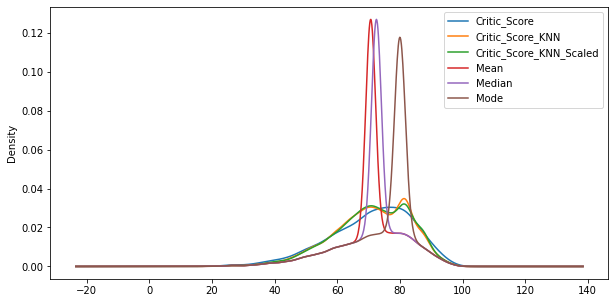

mean        std   min        50%        25%  \
Critic_Score             70.667269  13.457965  17.0  72.500000  62.000000   
Critic_Score_KNN         70.872449  12.367387  17.0  72.000000  63.000000   
Critic_Score_KNN_Scaled  70.921770  12.407628  17.0  72.000000  63.000000   
Mean                     70.667269  10.094613  17.0  70.667269  70.667269   
Median                   71.468782  10.135474  17.0  72.500000  71.000000   
Mode                     74.748776  11.105679  17.0  80.000000  71.000000   

                          75%   max  
Critic_Score             81.0  98.0  
Critic_Score_KNN         81.0  98.0  
Critic_Score_KNN_Scaled  81.0  98.0  
Mean                     74.0  98.0  
Median                   74.0  98.0  
Mode                     80.0  98.0

In [41]:
knn_impute_plot(vg_ds,'Critic_Score')

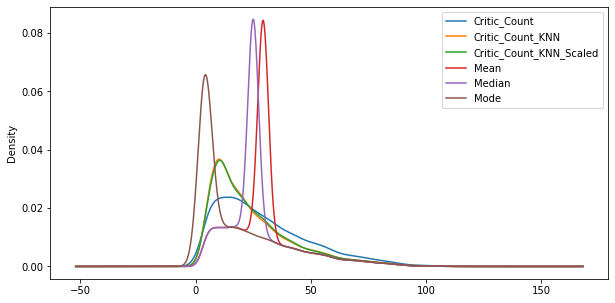

mean        std  min        50%   25%  \
Critic_Count             29.275772  19.985542  3.0  25.000000  14.0   
Critic_Count_KNN         24.411625  17.917840  3.0  19.000000  11.0   
Critic_Count_KNN_Scaled  24.566547  17.840681  3.0  19.333333  11.0   
Mean                     29.275772  14.990849  3.0  29.275772  22.0   
Median                   27.405837  15.140169  3.0  25.000000  22.0   
Mode                     18.221853  19.543471  3.0   8.000000   4.0   

                               75%    max  
Critic_Count             41.000000  113.0  
Critic_Count_KNN         33.000000  113.0  
Critic_Count_KNN_Scaled  33.000000  113.0  
Mean                     29.275772  113.0  
Median                   28.000000  113.0  
Mode                     28.000000  113.0

In [42]:
knn_impute_plot(vg_ds,'Critic_Count')

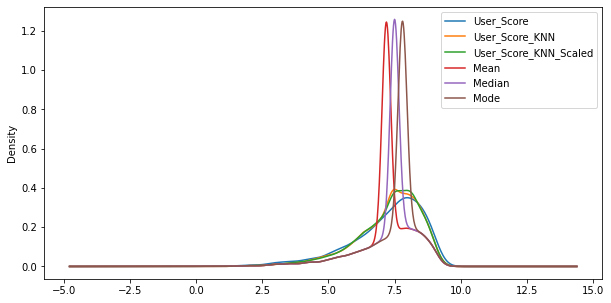

mean       std  min       50%       25%       75%  \
User_Score             7.190751  1.439805  0.0  7.500000  6.500000  8.200000   
User_Score_KNN         7.249571  1.273024  0.0  7.466667  6.600000  8.200000   
User_Score_KNN_Scaled  7.248188  1.282149  0.0  7.500000  6.600000  8.166667   
Mean                   7.190751  1.061195  0.0  7.190751  7.190751  7.600000   
Median                 7.331994  1.072318  0.0  7.500000  7.400000  7.600000   
Mode                   7.469013  1.103741  0.0  7.800000  7.400000  7.800000   

                       max  
User_Score             9.6  
User_Score_KNN         9.6  
User_Score_KNN_Scaled  9.6  
Mean                   9.6  
Median                 9.6  
Mode                   9.6

In [43]:
knn_impute_plot(vg_ds,'User_Score')

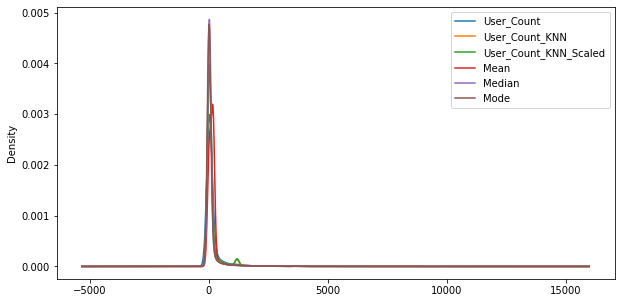

mean         std  min         50%        25%  \
User_Count             184.327780  608.288117  4.0   28.000000  12.000000   
User_Count_KNN         162.049691  507.963254  4.0   24.000000  10.666667   
User_Count_KNN_Scaled  166.549706  509.185143  4.0   25.333333  11.000000   
Mean                   184.327780  448.333211  4.0  184.327780  24.000000   
Median                 112.928420  455.046220  4.0   28.000000  24.000000   
Mode                   102.880392  457.049288  4.0    6.000000   6.000000   

                              75%      max  
User_Count              93.750000  10665.0  
User_Count_KNN          75.166667  10665.0  
User_Count_KNN_Scaled   79.000000  10665.0  
Mean                   184.327780  10665.0  
Median                  33.000000  10665.0  
Mode                    33.000000  10665.0

In [44]:
knn_impute_plot(vg_ds,'User_Count')

In [45]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
for i in cols:
  vg_ds[i] = imputer.fit_transform(vg_ds[[i]])

#### .info()
- There are 7 and 9 columns of object and float64 datatype.

##### Year Column datatype Conversion

In [46]:
vg_ds['Year_of_Release'] = vg_ds['Year_of_Release'].astype(int)

In [47]:
vg_ds['Year_of_Release'][0:5]

0    2006
1    1985
2    2008
3    2009
4    1996
Name: Year_of_Release, dtype: int64

#### .unique()
- Name column has many unique values, which won't be needed during our model building process. Hence, we will drop this column.
- The least number of unique value per column is 8 which is in Rating column.
- The maximum number of unique values is in Developer column. There are numerous ways we can deal with these types of column, such as some developer have only contributed 1 time in whole dataset, we can group values which belongs to 1-5 and bin them into new group or we can leave the column as it is.
- We will need to encode these columns by Frequency/Count encoder or we can use Ordinal encoder from scikit learn library to encode such number of unique values per column.

In [48]:
vg_ds_nunique = {i : vg_ds[i].nunique() for i in vg_ds.columns}
vg_ds_nunique

{'Name': 7382,
 'Platform': 28,
 'Year_of_Release': 38,
 'Genre': 12,
 'Publisher': 373,
 'NA_Sales': 402,
 'EU_Sales': 307,
 'JP_Sales': 244,
 'Other_Sales': 155,
 'Global_Sales': 620,
 'Critic_Score': 81,
 'Critic_Count': 107,
 'User_Score': 94,
 'User_Count': 834,
 'Developer': 1254,
 'Rating': 8}

In [49]:
vg_ds.drop(columns=['Name'],inplace = True)

#### .duplicated()
- There are 16 duplicate values in Dataset

In [50]:
vg_ds.duplicated().sum()

16

In [51]:
vg_ds.drop_duplicates(inplace = True)

# EDA


###### Object Column and Numerical Column Seperation

In [52]:
object_col = []
for i in vg_ds:
  if vg_ds[i].dtype == object:
    object_col.append(i)

In [53]:
object_col

['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']

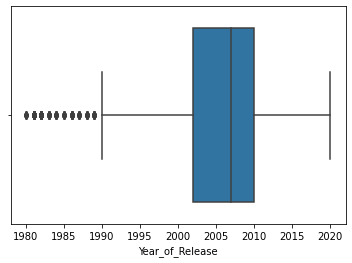

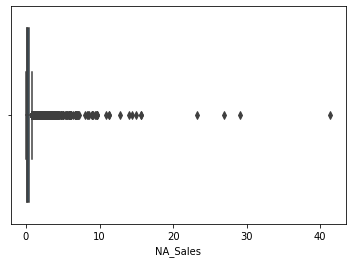

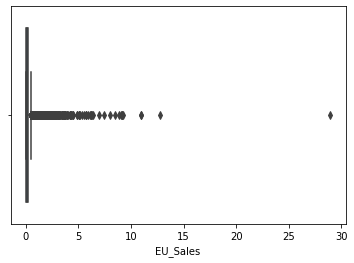

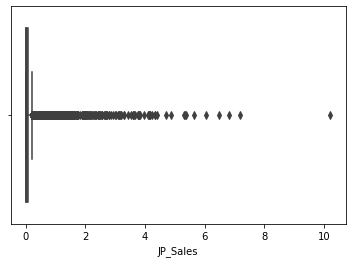

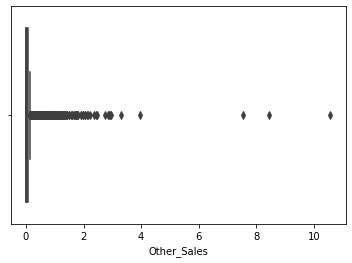

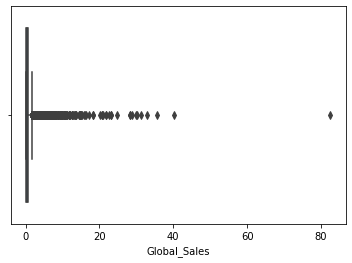

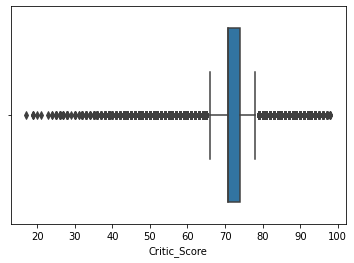

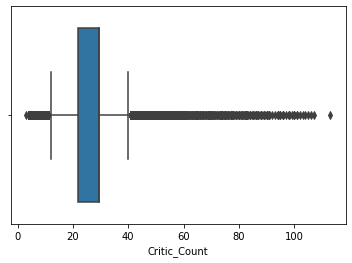

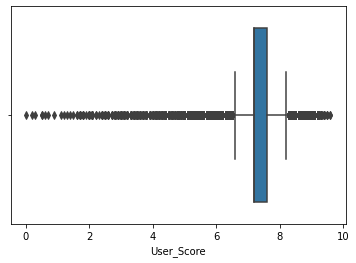

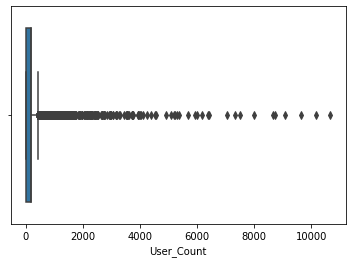

In [54]:
for i in num_col:
  sns.boxplot(x = vg_ds[i])
  plt.show()

In [55]:
num_col

['Year_of_Release',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'Critic_Score',
 'Critic_Count',
 'User_Score',
 'User_Count']

### Categorical Column Analysis

In [56]:
object_col

['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']

In [57]:
uni_cat_col(vg_ds,'Platform')

In [58]:
uni_cat_col(vg_ds,'Genre')

In [59]:
uni_cat_col(vg_ds,'Publisher')

In [60]:
uni_cat_col(vg_ds,'Developer')

In [61]:
uni_cat_col(vg_ds,'Rating')

### Numerical column Analysis

In [62]:
fig = px.scatter_matrix(vg_ds,dimensions=[i for i in num_col])
fig.update_layout(
    title='Univariate Numerical Analysis',
    width=2000,
    height=2000
)
fig.update_traces(diagonal_visible=False)
fig.show()

### Bivariate and Multivariate analysis

#### Group by Analysis

In [63]:
top_sales_sum(vg_ds,'Platform','Global_Sales',-5)

In [64]:
top_sales_sum(vg_ds,'Genre','Global_Sales',-5)

In [65]:
top_sales_sum(vg_ds,'Publisher','Global_Sales',-5)

In [66]:
top_sales_sum(vg_ds,'Rating','Global_Sales',-5)

In [67]:
top_sales_sum(vg_ds,'Developer','Global_Sales',-5)

#### Box Plot

In [68]:
fig = px.box(pd.melt(vg_ds), x="variable", y="value", points="outliers")
fig.show()

#### Correlation Matrix

In [69]:
x = list(vg_ds.corr().columns)
y = list(vg_ds.corr().index)
z = np.array(vg_ds.corr())

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Blues'
    )
fig.show()

#### Distribution Plot

In [70]:
hist_data = [vg_ds[i].values for i in num_col]
group_labels = [i for i in num_col]
fig1 = ff.create_distplot(hist_data, group_labels, curve_type='normal',show_rug=True,show_hist=True)
fig1.show()

# Model Building

### Encoding Object Variables

In [71]:
for i in object_col:
  print(i,'-->', vg_ds[i].nunique())

Platform --> 28
Genre --> 12
Publisher --> 373
Developer --> 1254
Rating --> 8


In [72]:
from sklearn.preprocessing import OrdinalEncoder
def Encode(df,column_name):
  copy = df[[column_name]]
  OE = OrdinalEncoder()
  df[column_name] = OE.fit_transform(df[[column_name]])
  c = {str(column_name) : copy.values.reshape(-1),str(column_name)+'_Encoded' : df[column_name].values.reshape(-1)}
  return pd.DataFrame(c)


In [73]:
Encode(vg_ds,'Platform')

Platform  Platform_Encoded
0          Wii              23.0
1          NES               9.0
2          Wii              23.0
3          Wii              23.0
4           GB               4.0
...        ...               ...
10806     XOne              27.0
10807       XB              26.0
10808      PSP              16.0
10809     WiiU              24.0
10810      PSV              17.0

[10811 rows x 2 columns]

In [74]:
Encode(vg_ds,'Genre')

Genre  Genre_Encoded
0            Sports           10.0
1          Platform            4.0
2            Racing            6.0
3            Sports           10.0
4      Role-Playing            7.0
...             ...            ...
10806      Platform            4.0
10807        Action            0.0
10808        Racing            6.0
10809        Action            0.0
10810      Fighting            2.0

[10811 rows x 2 columns]

In [75]:
Encode(vg_ds,'Publisher')

Publisher  Publisher_Encoded
0                Nintendo              222.0
1                Nintendo              222.0
2                Nintendo              222.0
3                Nintendo              222.0
4                Nintendo              222.0
...                   ...                ...
10806          Activision               13.0
10807          Activision               13.0
10808     Electronic Arts               94.0
10809          Activision               13.0
10810  Namco Bandai Games              215.0

[10811 rows x 2 columns]

In [76]:
Encode(vg_ds,'Developer')

Developer  Developer_Encoded
0                  Nintendo              749.0
1                 Not known              765.0
2                  Nintendo              749.0
3                  Nintendo              749.0
4                 Not known              765.0
...                     ...                ...
10806          Toys for Bob             1118.0
10807              Treyarch             1122.0
10808  Exient Entertainment              379.0
10809             Not known              765.0
10810        Spike Chunsoft             1008.0

[10811 rows x 2 columns]

In [77]:
Encode(vg_ds,'Rating')

Rating  Rating_Encoded
0          E             1.0
1         NK             6.0
2          E             1.0
3          E             1.0
4         NK             6.0
...      ...             ...
10806   E10+             2.0
10807      T             7.0
10808      E             1.0
10809     NK             6.0
10810      T             7.0

[10811 rows x 2 columns]

In [78]:
# platform_copy = vg_ds[['Platform']]

In [79]:
# for i in object_col:
#   i_copy = vg_ds[[i]]

In [80]:
# vg_ds1 = vg_ds.copy()

In [81]:
# 1

In [82]:
# a = vg_ds['Platform'].unique()

In [83]:
# len(vg_ds[vg_ds['Platform'] == 'Wii'])

In [84]:
# b = {}
# for i in a:
  # b[i] = len(vg_ds[vg_ds['Platform'] == i])

In [85]:
# b

In [86]:
# count = 0
# for i in b.values():
#   for m in b.values():
#     if i == m:
#       print('yes')
#       count += 1
#       print(count)
#     else:
#       print('No')

In [87]:
# len(b.values())

In [88]:
# b

In [89]:
# vg_ds1['Platform'] = vg_ds1['Platform'].map(b)

In [90]:
# vg_ds1['Platform']

In [91]:
# object_col

In [92]:
# vg_ds1['Genre']

In [93]:
# def count_encoding(df,col_name):
#   a = df[col_name].unique()
#   b = {}
#   for i in a:
#     b[i] = len(df[df[col_name] == i])

#   count = 0
#   for i in b.values():
#     for m in b.values():
#       if i == m:
#         print('yes')
#         count += 1
#         print(count)
#       else:
#         print('No')

#   df[col_name] = df[col_name].map(b)
#   print('total values',len(b))
#   return b

In [94]:
# count_encoding(vg_ds1,'Genre')

In [95]:
# vg_ds.shape

In [96]:
# count_encoding(vg_ds1,'Publisher')

In [97]:
# vg_ds1['Publisher']

In [98]:
# vg_ds1.isnull().sum()

In [99]:
vg_ds.head()

Platform  Year_of_Release  Genre  Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      23.0             2006   10.0      222.0     41.36     28.96      3.77   
1       9.0             1985    4.0      222.0     29.08      3.58      6.81   
2      23.0             2008    6.0      222.0     15.68     12.76      3.79   
3      23.0             2009   10.0      222.0     15.61     10.93      3.28   
4       4.0             1996    7.0      222.0     11.27      8.89     10.22   

   Other_Sales  Global_Sales  Critic_Score  Critic_Count  User_Score  \
0         8.45         82.53     76.000000     51.000000    8.000000   
1         0.77         40.24     70.667269     29.275772    7.190751   
2         3.29         35.52     82.000000     73.000000    8.300000   
3         2.95         32.77     80.000000     73.000000    8.000000   
4         1.00         31.37     70.667269     29.275772    7.190751   

   User_Count  Developer  Rating  
0   322.00000      749.0     1.0  
1   184.32778      765.0     6.0  
2   709.00000      749.0     1.0  
3   192.00000      749.0     1.0  
4   184.32778      765.0     6.0

In [100]:
vg_ds.shape

(10811, 15)

In [101]:
# Platform

In [102]:
# platform_copy = vg_ds[['Platform']]

In [103]:
# from sklearn.preprocessing import OrdinalEncoder

In [104]:
# OE = OrdinalEncoder()
# vg_ds['Platform'] = OE.fit_transform(vg_ds[['Platform']])
# vg_ds['Genre'] = OE.fit_transform(vg_ds[['Genre']])
# vg_ds['Publisher'] = OE.fit_transform(vg_ds[['Publisher']])
# vg_ds['Developer'] = OE.fit_transform(vg_ds[['Developer']])
# vg_ds['Rating'] = OE.fit_transform(vg_ds[['Rating']])

# # OE.categories_

In [105]:
# vg_ds['Platform']

In [106]:
# c = {
#     'Platform' : platform_copy.values.reshape(-1),
#  'Platform_Encoded' : vg_ds['Platform'].values.reshape(-1)
# }

In [107]:
# pd.DataFrame(c)

In [108]:
# platform_copy.nunique()

### Spliting Dataset into train and test

In [109]:
x = vg_ds.drop(columns=['Global_Sales'])
y = vg_ds[['Global_Sales']]

In [110]:
x.shape,y.shape

((10811, 14), (10811, 1))

In [111]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=42)

### Scaling Dataset

In [112]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [113]:
len(x_train),len(x_test),len(y_train),len(y_test)

(8648, 2163, 8648, 2163)

# Model building

In [114]:
callback = callback = tf.keras.callbacks.EarlyStopping(
    monitor="root_mean_squared_error",
    min_delta=0,
    patience=5,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
epochs = 100
accuracy = tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)
batch_size = 20

In [115]:
# # Model with ramdom selection of layers and no. of nuerons
# base_model = models.Sequential()
# base_model.add(layers.Dense(7, activation='relu', input_shape=(14,)))
# base_model.add(layers.Dense(1, activation = 'linear'))
# base_model._name = 'Baseline_model'
# base_model.summary()

In [116]:
# base_model.compile(
#     optimizer='sgd',
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [117]:
# base_history = base_model.fit(x_train
#                        , y_train
#                        , epochs=epochs
#                        , batch_size=batch_size
#                        , validation_data=(x_test, y_test)
#                        , verbose=0
#                        , callbacks = callback
#         )

In [118]:
# base_model.evaluate(x_test,y_test)

In [119]:
# y_test['Global_sales_base'] = base_model.predict(x_test)

In [120]:
# y_test

In [121]:
# n = pd.DataFrame(base_history.history)

In [122]:
# n

In [123]:
# import plotly.express as px

# fig = px.line(n, x=[i for i in base_history.epoch], y=["loss",'val_loss'], title='Loss Curve', height=500,width=00)
# fig.show()

In [124]:
# fig = px.line(n, x=[i for i in base_history.epoch], y=["root_mean_squared_error",'val_root_mean_squared_error'], title='RMSE Curve', height=500,width=800)
# fig.show()

In [125]:
# n

In [126]:
#ctrl+[ de-indents highlighted code. ctrl+] indents.
# ctl + /

In [127]:
# reg_model = models.Sequential()
# reg_model.add(layers.Dense(7, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(14,)))
# reg_model.add(layers.Dense(1, activation='linear'))
# reg_model._name = 'L2_Regularization_model'
# reg_model.summary()

In [128]:
# reg_model.compile(
#     optimizer='sgd',
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [129]:
# reg_history = reg_model.fit(x_train
#                        , y_train
#                        , epochs=epochs
#                        , batch_size=batch_size
#                        , validation_data=(x_test, y_test)
#                        , verbose=0
#                        , callbacks = callback
#         )

In [130]:
# reg_model.evaluate(x_test,y_test)

In [131]:
# n = pd.DataFrame(reg_history.history)
# fig = px.line(n, x=[i for i in reg_history.epoch], y=["loss",'val_loss'], title='Loss Curve', height=300,width=500)
# fig.show()

In [132]:
# fig = px.line(n, x=[i for i in reg_history.epoch], y=["root_mean_squared_error",'val_root_mean_squared_error'], title='RMSE Curve', height=300,width=630)
# fig.show()

In [133]:
# i am making a function for plots...yes
# first i will build a model builder function.
# then i will build ploting function
# model building func - done
# model prediction func - done
# model ploting func - done

# now let's test it <----
# i will make batch norm model now because i have already (i also dont know BN right now) - i will learn theory later on after submitting this assignment.

In [134]:
def model_training_regression(model):
  model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  history = model.fit(x_train
                       , y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_data=(x_test, y_test)
                       , verbose=0
                       , callbacks = callback
        )
  print(model.evaluate(x_test,y_test))

  return history

In [135]:
def model_prediction_regression(model,name='Model'):
  y_test[f'Global_sales_{name}'] = model.predict(x_test)
  return y_test

In [136]:
def model_plots_regression(model):

  n = pd.DataFrame(model.history)

  fig = px.line(n, x=[i for i in model.epoch], y=["loss",'val_loss'], title='Loss Curve', height=300,width=500)
  fig.show()

  fig = px.line(n, x=[i for i in model.epoch], y=["root_mean_squared_error",'val_root_mean_squared_error'], title='RMSE Curve', height=300,width=630)
  fig.show()

  return n

#### Baseline Model

In [137]:
base_model = models.Sequential()
base_model.add(layers.Dense(7, activation='relu', input_shape=(14,)))
base_model.add(layers.Dense(1, activation = 'linear'))
base_model._name = 'Baseline_model'
base_model.summary()

Model: "Baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 105       
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [138]:
base_history = model_training_regression(base_model)

Epoch 51: early stopping
68/68 [==============================] - 0s 1ms/step - loss: 0.4940 - root_mean_squared_error: 0.7028
[0.49396297335624695, 0.7028250098228455]


In [139]:
model_prediction_regression(base_model,name = 'Baseline_model')

Global_Sales  Global_sales_Baseline_model
5154           0.37                     0.428283
8077           0.18                     0.290134
10283          0.11                     0.228122
5281           0.35                     0.419135
5686           0.32                     0.491291
...             ...                          ...
6586           0.25                     0.418381
8892           0.15                     0.265288
4886           0.39                     0.441113
8431           0.17                     0.336016
2067           1.00                     0.862158

[2163 rows x 2 columns]

In [140]:
model_plots_regression(base_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.211963                 0.460394  0.488636                     0.699025
1   0.028890                 0.169971  0.484406                     0.695993
2   0.010218                 0.101084  0.476285                     0.690134
3   0.004017                 0.063381  0.494885                     0.703480
4   0.002024                 0.044991  0.481137                     0.693640
5   0.001177                 0.034301  0.485932                     0.697088
6   0.000753                 0.027445  0.489418                     0.699584
7   0.000494                 0.022236  0.496481                     0.704614
8   0.000340                 0.018445  0.487785                     0.698416
9   0.000242                 0.015570  0.489862                     0.699902
10  0.000177                 0.013319  0.492047                     0.701461
11  0.000133                 0.011515  0.490110                     0.700078
12  0.000105                 0.010262  0.491637                     0.701168
13  0.000083                 0.009137  0.493726                     0.702657
14  0.000069                 0.008318  0.491396                     0.700996
15  0.000058                 0.007604  0.494516                     0.703218
16  0.000052                 0.007179  0.493203                     0.702284
17  0.000045                 0.006717  0.492446                     0.701745
18  0.000042                 0.006445  0.493369                     0.702402
19  0.000039                 0.006213  0.493925                     0.702798
20  0.000036                 0.006031  0.494333                     0.703088
21  0.000035                 0.005926  0.492654                     0.701893
22  0.000034                 0.005833  0.493836                     0.702735
23  0.000033                 0.005751  0.493024                     0.702157
24  0.000033                 0.005720  0.494218                     0.703007
25  0.000033                 0.005706  0.492709                     0.701932
26  0.000032                 0.005640  0.494061                     0.702895
27  0.000032                 0.005645  0.492991                     0.702133
28  0.000031                 0.005600  0.493069                     0.702189
29  0.000031                 0.005604  0.494159                     0.702964
30  0.000032                 0.005634  0.493457                     0.702465
31  0.000031                 0.005595  0.493355                     0.702392
32  0.000031                 0.005605  0.493798                     0.702708
33  0.000031                 0.005595  0.494314                     0.703074
34  0.000031                 0.005594  0.493432                     0.702447
35  0.000031                 0.005585  0.494106                     0.702927
36  0.000031                 0.005587  0.494700                     0.703349
37  0.000031                 0.005590  0.497910                     0.705627
38  0.000031                 0.005584  0.494523                     0.703223
39  0.000031                 0.005581  0.494271                     0.703044
40  0.000031                 0.005587  0.494606                     0.703282
41  0.000031                 0.005575  0.493725                     0.702656
42  0.000031                 0.005570  0.494512                     0.703216
43  0.000031                 0.005568  0.494176                     0.702976
44  0.000031                 0.005563  0.494677                     0.703333
45  0.000031                 0.005560  0.494452                     0.703172
46  0.000031                 0.005578  0.494100                     0.702923
47  0.000031                 0.005584  0.494545                     0.703239
48  0.000032                 0.005616  0.495351                     0.703812
49  0.000031                 0.005604  0.492927                     0.702087
50  0.000031                 0.005562  0.493963                     0.702825

#### L2 Regularized model

In [141]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(7, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(14,)))
reg_model.add(layers.Dense(1, activation='linear'))
reg_model._name = 'L2_Regularization_model'
reg_model.summary()

Model: "L2_Regularization_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [142]:
reg_history = model_training_regression(reg_model)

68/68 [==============================] - 0s 1ms/step - loss: 0.2503 - root_mean_squared_error: 0.4985
[0.25031232833862305, 0.49852585792541504]


In [143]:
model_prediction_regression(reg_model,name = 'L2_Regularization_model')

Global_Sales  Global_sales_Baseline_model  \
5154           0.37                     0.428283   
8077           0.18                     0.290134   
10283          0.11                     0.228122   
5281           0.35                     0.419135   
5686           0.32                     0.491291   
...             ...                          ...   
6586           0.25                     0.418381   
8892           0.15                     0.265288   
4886           0.39                     0.441113   
8431           0.17                     0.336016   
2067           1.00                     0.862158   

       Global_sales_L2_Regularization_model  
5154                               0.428443  
8077                               0.288877  
10283                              0.227467  
5281                               0.419944  
5686                               0.488930  
...                                     ...  
6586                               0.418072  
8892                               0.265790  
4886                               0.442898  
8431                               0.335028  
2067                               0.859934  

[2163 rows x 3 columns]

In [144]:
model_plots_regression(reg_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.239227                 0.480423  0.325601                     0.563412
1   0.051844                 0.209327  0.309035                     0.548780
2   0.037240                 0.171683  0.264795                     0.507100
3   0.030060                 0.150159  0.273284                     0.515648
4   0.023725                 0.128239  0.254698                     0.497517
..       ...                      ...       ...                          ...
95  0.001922                 0.006248  0.250037                     0.498163
96  0.001899                 0.006215  0.250368                     0.498517
97  0.001876                 0.006177  0.249392                     0.497558
98  0.001855                 0.006177  0.250389                     0.498582
99  0.001833                 0.006191  0.250312                     0.498526

[100 rows x 4 columns]

#### Batch Normalization model

In [145]:
Batch_norm_model = keras.Sequential()
Batch_norm_model.add(layers.Dense(7,input_shape = (14,),activation = 'relu'))
Batch_norm_model.add(layers.BatchNormalization())
Batch_norm_model.add(layers.Dense(1,activation = 'linear'))

In [146]:
Batch_norm_history = model_training_regression(Batch_norm_model)

Epoch 38: early stopping
68/68 [==============================] - 0s 2ms/step - loss: 0.2429 - root_mean_squared_error: 0.4929
[0.24291503429412842, 0.49286413192749023]


In [147]:
model_prediction_regression(Batch_norm_model,name = 'Batch_Norm')

Global_Sales  Global_sales_Baseline_model  \
5154           0.37                     0.428283   
8077           0.18                     0.290134   
10283          0.11                     0.228122   
5281           0.35                     0.419135   
5686           0.32                     0.491291   
...             ...                          ...   
6586           0.25                     0.418381   
8892           0.15                     0.265288   
4886           0.39                     0.441113   
8431           0.17                     0.336016   
2067           1.00                     0.862158   

       Global_sales_L2_Regularization_model  Global_sales_Batch_Norm  
5154                               0.428443                 0.556299  
8077                               0.288877                 0.516034  
10283                              0.227467                 0.387163  
5281                               0.419944                 0.511817  
5686                               0.488930                 0.800846  
...                                     ...                      ...  
6586                               0.418072                 0.461679  
8892                               0.265790                 0.299596  
4886                               0.442898                 0.430970  
8431                               0.335028                 0.353985  
2067                               0.859934                 0.870606  

[2163 rows x 4 columns]

In [148]:
model_plots_regression(Batch_norm_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   1.394527                 1.180901  0.274865                     0.524276
1   0.828827                 0.910400  0.955190                     0.977338
2   0.741186                 0.860922  0.274408                     0.523839
3   0.640829                 0.800518  0.261799                     0.511663
4   0.589280                 0.767646  0.311158                     0.557816
5   0.535318                 0.731654  0.200689                     0.447984
6   0.530040                 0.728038  0.387908                     0.622823
7   0.474667                 0.688961  0.262223                     0.512077
8   0.508687                 0.713223  0.402530                     0.634452
9   0.519796                 0.720969  0.201433                     0.448813
10  0.454787                 0.674379  0.539333                     0.734393
11  0.471969                 0.687000  0.470614                     0.686013
12  0.460542                 0.678633  0.219330                     0.468327
13  0.432137                 0.657371  1.390526                     1.179206
14  0.500101                 0.707178  0.207662                     0.455699
15  0.512186                 0.715672  0.285880                     0.534677
16  0.411392                 0.641399  0.176516                     0.420138
17  0.458584                 0.677189  0.243718                     0.493678
18  0.442351                 0.665095  0.245165                     0.495141
19  0.440336                 0.663578  0.193967                     0.440417
20  0.402548                 0.634467  0.297921                     0.545821
21  0.416414                 0.645301  0.227291                     0.476750
22  0.437925                 0.661759  0.336927                     0.580454
23  0.504287                 0.710132  0.222973                     0.472200
24  0.395148                 0.628608  0.274755                     0.524171
25  0.399079                 0.631727  0.256691                     0.506647
26  0.386247                 0.621487  0.198083                     0.445065
27  0.396781                 0.629905  0.278033                     0.527288
28  0.391977                 0.626081  0.177330                     0.421106
29  0.347724                 0.589681  0.211683                     0.460091
30  0.395548                 0.628926  0.408915                     0.639464
31  0.371140                 0.609212  0.382556                     0.618511
32  0.344700                 0.587111  0.197022                     0.443871
33  0.362521                 0.602097  0.177761                     0.421617
34  0.361019                 0.600849  0.369883                     0.608180
35  0.373201                 0.610902  0.257833                     0.507773
36  0.353548                 0.594599  0.196790                     0.443610
37  0.357906                 0.598252  0.242915                     0.492864

#### Dropout layer model

In [149]:
Dropout_model = keras.Sequential()
Dropout_model.add(layers.Dense(7,input_shape = (14,),activation = 'relu'))
Dropout_model.add(layers.Dropout(0.01))
Dropout_model.add(layers.Dense(1,activation = 'linear'))

In [150]:
Dropout_history = model_training_regression(Dropout_model)

Epoch 18: early stopping
68/68 [==============================] - 0s 1ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228
[0.1787737011909485, 0.4228163957595825]


In [151]:
model_prediction_regression(Dropout_model,name = 'Dropout_model')

Global_Sales  Global_sales_Baseline_model  \
5154           0.37                     0.428283   
8077           0.18                     0.290134   
10283          0.11                     0.228122   
5281           0.35                     0.419135   
5686           0.32                     0.491291   
...             ...                          ...   
6586           0.25                     0.418381   
8892           0.15                     0.265288   
4886           0.39                     0.441113   
8431           0.17                     0.336016   
2067           1.00                     0.862158   

       Global_sales_L2_Regularization_model  Global_sales_Batch_Norm  \
5154                               0.428443                 0.556299   
8077                               0.288877                 0.516034   
10283                              0.227467                 0.387163   
5281                               0.419944                 0.511817   
5686                               0.488930                 0.800846   
...                                     ...                      ...   
6586                               0.418072                 0.461679   
8892                               0.265790                 0.299596   
4886                               0.442898                 0.430970   
8431                               0.335028                 0.353985   
2067                               0.859934                 0.870606   

       Global_sales_Dropout_model  
5154                     0.401978  
8077                     0.270782  
10283                    0.219121  
5281                     0.417266  
5686                     0.466328  
...                           ...  
6586                     0.441215  
8892                     0.254134  
4886                     0.439096  
8431                     0.331423  
2067                     0.842833  

[2163 rows x 5 columns]

In [152]:
model_plots_regression(Dropout_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.398958                 0.631632  0.241572                     0.491499
1   0.060100                 0.245152  0.208346                     0.456450
2   0.034781                 0.186496  0.206850                     0.454807
3   0.018498                 0.136006  0.181961                     0.426569
4   0.020262                 0.142345  0.177457                     0.421257
5   0.063515                 0.252023  0.178168                     0.422100
6   0.024903                 0.157806  0.167500                     0.409268
7   0.016257                 0.127502  0.185212                     0.430362
8   0.013492                 0.116153  0.176071                     0.419608
9   0.020951                 0.144743  0.177858                     0.421732
10  0.014065                 0.118595  0.223265                     0.472510
11  0.052252                 0.228587  0.150507                     0.387952
12  0.007285                 0.085353  0.179306                     0.423446
13  0.009553                 0.097738  0.186804                     0.432208
14  0.016135                 0.127025  0.185095                     0.430227
15  0.011404                 0.106790  0.189262                     0.435042
16  0.026809                 0.163734  0.167134                     0.408820
17  0.009920                 0.099598  0.178774                     0.422816

#### Neuro Model (Neurons in Dense layer increased)

In [153]:
neuro_model = keras.Sequential()

neuro_model.add(layers.Dense(14,input_shape = (14,),activation = 'relu'))
Dropout_model.add(layers.Dropout(0.01))

neuro_model.add(layers.Dense(7,activation = 'relu'))
Dropout_model.add(layers.Dropout(0.01))

neuro_model.add(layers.Dense(1,activation = 'linear'))

In [154]:
neuro_model_history = model_training_regression(neuro_model)

Epoch 78: early stopping
68/68 [==============================] - 0s 1ms/step - loss: 0.1416 - root_mean_squared_error: 0.3763
[0.14159904420375824, 0.37629643082618713]


In [155]:
model_prediction_regression(neuro_model,name = 'Neuro_model')

Global_Sales  Global_sales_Baseline_model  \
5154           0.37                     0.428283   
8077           0.18                     0.290134   
10283          0.11                     0.228122   
5281           0.35                     0.419135   
5686           0.32                     0.491291   
...             ...                          ...   
6586           0.25                     0.418381   
8892           0.15                     0.265288   
4886           0.39                     0.441113   
8431           0.17                     0.336016   
2067           1.00                     0.862158   

       Global_sales_L2_Regularization_model  Global_sales_Batch_Norm  \
5154                               0.428443                 0.556299   
8077                               0.288877                 0.516034   
10283                              0.227467                 0.387163   
5281                               0.419944                 0.511817   
5686                               0.488930                 0.800846   
...                                     ...                      ...   
6586                               0.418072                 0.461679   
8892                               0.265790                 0.299596   
4886                               0.442898                 0.430970   
8431                               0.335028                 0.353985   
2067                               0.859934                 0.870606   

       Global_sales_Dropout_model  Global_sales_Neuro_model  
5154                     0.401978                  0.433060  
8077                     0.270782                  0.290580  
10283                    0.219121                  0.231510  
5281                     0.417266                  0.411659  
5686                     0.466328                  0.496335  
...                           ...                       ...  
6586                     0.441215                  0.416307  
8892                     0.254134                  0.266308  
4886                     0.439096                  0.433005  
8431                     0.331423                  0.337759  
2067                     0.842833                  0.866365  

[2163 rows x 6 columns]

In [156]:
model_plots_regression(neuro_model_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.225602                 0.474976  0.163071                     0.403821
1   0.037296                 0.193121  0.155584                     0.394442
2   0.025496                 0.159675  0.146029                     0.382138
3   0.017129                 0.130879  0.146177                     0.382331
4   0.011983                 0.109468  0.141683                     0.376408
..       ...                      ...       ...                          ...
73  0.000205                 0.014324  0.140413                     0.374717
74  0.000205                 0.014325  0.140554                     0.374905
75  0.000209                 0.014463  0.141072                     0.375595
76  0.000208                 0.014417  0.140067                     0.374255
77  0.000218                 0.014760  0.141599                     0.376296

[78 rows x 4 columns]

#### Combine model 

In [157]:
combine_model = keras.Sequential()

combine_model.add(layers.Dense(14,input_shape = (14,),activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))

combine_model.add(layers.Dense(7,activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))

combine_model.add(layers.Dense(1,activation = 'linear'))

In [158]:
combine_model_history = model_training_regression(combine_model)

Epoch 14: early stopping
68/68 [==============================] - 0s 1ms/step - loss: 0.1297 - root_mean_squared_error: 0.3357
[0.129659503698349, 0.3357020616531372]


In [159]:
model_prediction_regression(combine_model,name = 'combine_model')

Global_Sales  Global_sales_Baseline_model  \
5154           0.37                     0.428283   
8077           0.18                     0.290134   
10283          0.11                     0.228122   
5281           0.35                     0.419135   
5686           0.32                     0.491291   
...             ...                          ...   
6586           0.25                     0.418381   
8892           0.15                     0.265288   
4886           0.39                     0.441113   
8431           0.17                     0.336016   
2067           1.00                     0.862158   

       Global_sales_L2_Regularization_model  Global_sales_Batch_Norm  \
5154                               0.428443                 0.556299   
8077                               0.288877                 0.516034   
10283                              0.227467                 0.387163   
5281                               0.419944                 0.511817   
5686                               0.488930                 0.800846   
...                                     ...                      ...   
6586                               0.418072                 0.461679   
8892                               0.265790                 0.299596   
4886                               0.442898                 0.430970   
8431                               0.335028                 0.353985   
2067                               0.859934                 0.870606   

       Global_sales_Dropout_model  Global_sales_Neuro_model  \
5154                     0.401978                  0.433060   
8077                     0.270782                  0.290580   
10283                    0.219121                  0.231510   
5281                     0.417266                  0.411659   
5686                     0.466328                  0.496335   
...                           ...                       ...   
6586                     0.441215                  0.416307   
8892                     0.254134                  0.266308   
4886                     0.439096                  0.433005   
8431                     0.331423                  0.337759   
2067                     0.842833                  0.866365   

       Global_sales_combine_model  
5154                     0.382750  
8077                     0.269570  
10283                    0.182393  
5281                     0.483379  
5686                     0.489681  
...                           ...  
6586                     0.406362  
8892                     0.320250  
4886                     0.348884  
8431                     0.266448  
2067                     0.869812  

[2163 rows x 7 columns]

In [160]:
model_plots_regression(combine_model_history)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   1.564564                 1.241285  0.226415                     0.450115
1   0.160459                 0.370530  0.172609                     0.387008
2   0.151337                 0.359045  0.187236                     0.406729
3   0.111222                 0.299555  0.166686                     0.381383
4   0.097536                 0.276665  0.163597                     0.377960
5   0.202439                 0.426746  0.129205                     0.330330
6   0.076575                 0.238384  0.173625                     0.392601
7   0.108544                 0.298731  0.150417                     0.362389
8   0.040138                 0.145868  0.156119                     0.370765
9   0.106053                 0.295942  0.164309                     0.382131
10  0.105267                 0.295213  0.277202                     0.509319
11  0.043590                 0.160707  0.400595                     0.619085
12  0.044481                 0.164552  0.153037                     0.368511
13  0.039004                 0.148076  0.129660                     0.335702

# keras tuner

In [161]:
base_model.summary(
    
)

Model: "Baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 105       
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [162]:
pip install keras-tuner --upgrade -q

In [163]:
import keras_tuner
from tensorflow import keras

In [164]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  
  model.add(keras.layers.Dense(1, activation='linear'))
  model.compile(loss='mse',optimizer='sgd')
  return model

In [165]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='loss', # chaange objective
    max_trials=10)

In [166]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 2 Complete [00h 00m 55s]
loss: 0.0006148085813038051

Best loss So Far: 0.00020119210239499807
Total elapsed time: 00h 02m 03s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
16                |8                 |units

Epoch 1/100
271/271 [==============================] - 1s 2ms/step - loss: 0.2458 - val_loss: 0.1670
Epoch 2/100
271/271 [==============================] - 1s 2ms/step - loss: 0.0676 - val_loss: 0.1640
Epoch 3/100
271/271 [==============================] - 1s 2ms/step - loss: 0.0470 - val_loss: 0.1257
Epoch 4/100
271/271 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.1379
Epoch 5/100
271/271 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1170
Epoch 6/100
271/271 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.1114
Epoch 7/100
271/271 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.1019
Epoch 8/100
271/271 [==============

KeyboardInterrupt: ignored

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.results_summary()

In [ ]:
best_model.summary

In [ ]:
best_model.build(input_shape = (None,14))
best_model.summary()

In [ ]:
#  Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
histoottot = model.fit(x_train, y=y_train, epochs=10)

In [ ]:
histoottot.history

In [ ]:
model.evaluate(x_test,y_test)